# Convolutional Neural Networks with PyTorch
> LPC Statistics Course 2021, Fermilab <br>
> INFN SOS 2022, Paestum, Italy<br>
> AEPSHEP 2024, Thailand<br>
> Harrison B. Prosper

## Introduction
In this tutorial, we use a simple convolutional neural network (CNN) to classify images of quark and gluon-initiated jets.

Each image in the [QuarkGluon](https://www.kaggle.com/datasets/anonymous2506/quarkgluon) kaggle dataset is represented by a $(125, 125)$ matrix. This notebook uses a subset of 60,000 images from that dataset, which have already been processed as follows.
  1. The images have been coarse-grained to images of shape (25, 25).
  2. They are then cropped to (16, 16) images after placing the brightest pixel at the same (off-center) point in the image.
  3. The 3 image planes have been averaged and the matrix element values are mapped to the set $[0, \cdots, 1]$ by dividing every pixel by 255.
    
During training (and testing), a **batch** of images must be stored in a 4-index tensor $\mathbf{x}_{ncij}$ of **shape** $(N, C, H, W)$. Think of this as a 4-dimensional array each cell of which contains a pixel value. The first index (dim = 0) labels the ordinal value (position) of an image in a batch of $N$ images; the second index (dim = 1) labels the number of **channels**, $C$, that is, image planes, which for our images is $C = 1$, while the last two indices (dim = 2, 3) label the pixels of an image of height and width $H$ and $W$, respectively. 

## Model

A typical convolutional neural network (CNN) comprises an alternating sequence of convolutional and coarse-graining (or **down-sampling**) layers ending with a fully-connected feed-forward neural network. A convolutional layer cross-correlates its inputs with a kernel, while (typically) increasing the number of output channels. The coarse-graining layer takes in one or more image planes, that is, channels, and creates multi-channel output images of smaller size. Here is a high-level view of the model we shall fit,

\begin{align*}
\mathbf{y} & = \text{softmax}(\, \text{flatten} (\, \text{g}(\mathbf{b}_1 + {\rm cc}(\mathbf{w}_1, \, \text{g}(\mathbf{b}_0 + {\rm cc}(\mathbf{w}_0, \, \mathbf{x}) \, ) \, ) \, ) \, ) \, ),
\end{align*}

where $\mathbf{b}$ and $\mathbf{w}$, the biases and weights, are the parameters of the model and the functions **softmax**, **flatten**, **g**, and **cc** are defined as follows:

  * __softmax__ For $K$ output classes, 
\begin{align*}
\text{softmax}(x)_k & = \frac{\exp(x_{k})}{\sum_{j=1}^{K} \exp(x_{j})} ,
\end{align*}
where $x_{k}$ denotes the $k^\text{th}$ output of the previous layer. The
softmax function
bounds the output values to the unit interval and ensure that 
their sum is unity. 

  * __flatten__ Given tensor $\mathbf{x}$, this function restructures $\mathbf{x}$ into a 1D tensor (a 1D array).

  * __g__ Given tensor $\mathbf{x}$, this function operates element-wise on its inputs and returns 
  \begin{align}
  \text{f}(\mathbf{x}) = \text{relu}(\,\text{maxpool}(\,\mathbf{x}\,)\,),
  \end{align}
  where relu, and maxpool are defined below.

  * __cc__ Given tensors $\mathbf{w}$ and $\mathbf{x}$, this function returns their cross-correlation.
    \begin{align}
    \mathbf{x}_{kij} = \sum_{c=1}^{C} \sum_{r=-2}^2 \sum_{s=-2}^2  \mathbf{x}_{c,\, i+r,\,j+s} \, \mathbf{w}_{kcrs} .
    \end{align}

  * __relu__ Given tensor $\mathbf{x}$, the function 
\begin{align*}
{\rm relu}(x) &= \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}
is applied
*element-wise*, that is, to every element of the tensor.

  * __maxpool__ Given tensor $\mathbf{x}$, this function uses a moveable window to apply a coarse-graining operation over $\mathbf{x}$. In this tutorial, the moveable window  splits the tensor into non-overlapping pieces. For each piece, the maximum pixel value within that piece is returned. For example, if $\mathbf{x}$ is a 2D tensor, e.g., a matrix, of shape (16, 16), and the window is of shape (2, 2), maxpool splits the original matrix into $8 \times 8$ non-overlapping pieces of shape (2, 2) and returns the maximum value within each piece, thereby creating a new matrix of shape (8, 8).

A high-level view is a good way to represent the structure of a model.  But it is also good to try to understand the details...at least once. As is often true, a detailed mathematical description of a complicated function is made easier using an example. 

### Convolutional layer
The data into the first convolutional layer are a sequence of single channel jet images $\mathbf{x}$ of shape $(N, 1, 16, 16)$, that is, the data  form a tensor comprising a batch of $N$ images, each with a single channel ($C = 1)$ and each a $(16, 16)$ matrix of pixels. This tensor is cross-correlated with a 4D tensor of weights $\mathbf{w}_0$ with shape $(4, 1, 3, 3)$. We shall refer to the latter as a **kernel** and each of its $4 \times 1$, $(3, 3)$, matrices (or 2D tensors) as a **filter**. The first index of the kernel is the number of **output channels** (here, 4), the second is the number of **input channels** (here, 1). Therefore, a given $(3, 3)$ filter is identified by two indices: its output and input channel numbers. The last two indices of the kernel are the height (3) and width (3), respectively, of its filters. 

(Unfortunately, the jargon is not consistent across the machine learning literature. What we call a filter is indeed often referred to as a filter, but it is also called a kernel, and what we call a kernel, that is, a stack of one or more filters, often has no specific name attached to it!) 

The operation of the convolutional layer for filters with odd-numbered height and width, e.g. $(3, 3)$, can be written as

\begin{align}
    (\mathbf{b}_0)_k + (\mathbf{w}_0 \otimes \mathbf{x})_{nkij} &= (\mathbf{b}_0)_k + \sum_{c=0}^{C-1} \sum_{r=-2}^2 \sum_{s=-2}^2  \mathbf{x}_{nc,\, i+r,\,j+s} \, (\mathbf{w}_0)_{kcrs}, \quad i, j = 0,\cdots, 15,
\end{align}

where we have chosen to label the central matrix element of a filter with the indices $(0, 0)$ and the other elements with indices that can be positive or negative integers. In the above expression, for a given pixel $i, j$, the filter labeled $k, c$, namely the matrix $(\mathbf{w}_0)_{kc}$ with matrix elements $(\mathbf{w}_0)_{kcrs}$ is cross-correlated with channel $c$ of input image $n$ and a sum over the cross-correlated input channels, that is, over the index $c$, is performed resulting in $k$ output images.

However, for the above computations to work as shown, we need (in effect) to surround each image with extra strips of pixels. This operation is called **padding**. We pad each image with 1 strip of pixels with value zero. This padding makes it possible to center each of the $4 \times 1$ $(3, 3)$ filters on every pixel, $i, j$, of the image. We are free to make other choices.

Since the input image is a $(16, 16)$ matrix padded with 1 strip of pixels around the boundary, and each of the 4 filterd is a $(3, 3)$ matrix,
the output of the convolution step will be a tensor of shape $(N, 4, 16, 16)$ provided that we use a **stride** of 1, that is, if during the cross-correlation we shift the filters a horizontal or vertical step of 1 pixel. Other choices are possible. Therefore, by
construction, the output of this convolutional layer is $N$ 4-channel images of the same size as the original, namely $(16, 16)$.

### Coarse-graining layer
A convolutional layer is often followed by a coarse-graining, that is, down-sampling, layer that reduces the number of pixels per image. In this tutorial, the number of pixels in the image created by the convolutional layer is reduced by a factor 2 in both directions; that is, each of the 4 channels of the $(16, 16)$ image is down-sampled to an $(8, 8)$ channel by replacing the corresponding group of pixels of shape $(2, 2)$ with a pixel whose value is set to the largest value among the group of 4 pixels.  This operation, called **max-pooling**, can be expressed as

\begin{align}
    {\rm maxpool}(O)_{nkij} &= \max{ \{O_{nk,\, 2i + r,\, 2j + s} \}_{r,\,s = 0, 1} } \quad i, j = 0,\cdots, 15,
\end{align}

where $O$ is the output of a convolutional layer. Again, other choices are possible.

After max-pooling, the output tensor has shape $(N, 4, 8, 8)$. A relu **activation function** is applied to each element of this tensor and completes one sequence of operations: cross-correlation, down-sampling, and non-linear activation. 

A second convolutional layer follows whose input must match the output of the previous max-pooling operation, which contains $N$ sequences of images, each with 4 channels, and each an $(8, \, 8)$ matrix padded with a 1-pixel boundary. The kernel in this layer contains $4 \times 4$, $(3, 3)$, filters, that is, it is of shape $(4, 4, 3, 3)$. For a given input channel $c$, each of the $4 \times 4$ $(3, 3)$ filters of the sub-kernel $(4, c, 3, 3)$ is cross-correlated with input channel $c$. The cross-correlated input channels are then summed pixel by pixel over the 4 channels to yield  an 4-channel output image from this layer. The output, therefore, is a tensor of shape $(N, 4, 8, 8)$.

Finally, a second max-pooling layer is applied, which transforms the 4-channel image of 2D size $(8, 8)$ to an 4-channel image of size $(4, 4)$. The image is then flattened into a 1D tensor (basically, a 1D array) of size $4 \times 4 \times 4 = 64$, which are the inputs of the final linear layer with 2 outputs. Finally, a softmax function is applied to normalize the sum of the two outputs to one.


### Discussion
The net effect of the sequence of nested layers, prior to flattening, is to transform each $(16, 16)$ input image into a 4-channel (4, 4) output image. The hope is that the output image captures the most relevant features of the input image thereby improving the accuracy of the subsequent classification. But why use cross-correlation?

The intuition behind the cross-correlation operation is that natural images tend to have similar features in different parts of the image. A filter that is sensitive to vertical features would tend to produce an output image that enhances vertical features, while suppressing the expression of horizontal features. It therefore seems plausible that if one could design filters that are sensitive to different image features, the set of filters could potentially transform an image into another in which the most relevant features are enhanced while the least relevant are suppressed. 

In the early days of image recognition systems, researchers tried to describe in software what they considered to be the most relevant features in images. This proved to be extremely difficult and success was limited. Today hand-coding is no longer necessary because the values of the parameters of the kernels can be determined automatically by minimizing an appropriate (average) loss function. However, the mere fact that a large number of images is needed to fit these parameters is evidence that current machine learning methods and models, while spectacularly successful, are still far removed from the internal models humans use to learn about the world. 

A young child need be shown labeled objects, cat, dog, doll, truck, car, just a few times before being able to classify them correctly. The child can do this even when the objects are presented to her in orientations that differ from the ones used during the "training phase". This extraordinary ability suggests that the child's brain constructs a fault tolerant model of each object using only its most relevant features and is able to match rapidly the input image with the stored, or more likely auto-reconstructed, fault tolerant model. The model is clearly fault tolerant because the child is able to ignore "faults" such as viewing the objects in lighting that differs from that used during the "training phase", or ignoring the fact that now the car has lost a couple of wheels or the doll is now wearing different clothes and so on. 

In spite of the truly impressive recent successes, it is clear that machine learning-based artificial intelligence still has a long way to go. Of course, it could be that the age-old goal of building machines that think like humans is simply the wrong goal. After all, there are already many instances in which researchers have inadvertently succeeded in producing machines that mimic our prejudices, which is hardly progress. Therefore, perhaps we should embrace the "artificial" in artificial intelligence and the possibility that these machines will inevitably "think" differently from us. The trick, of course, is to have them "think" in a way that improves the human condition. It would not be helpful if, for example, our super-intelligent machine concluded that the best way to solve rapid climate change is to eliminate one of its culprits, namely, the species Homo sapiens!

In [57]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib as mp
import matplotlib.pyplot as plt

# to plot pixelized images
import imageio.v3 as im

# PyTorch
import torch
import torch.nn as nn

# to load objects into memory
import joblib as jb

# to reload modules
import importlib

from glob import glob

%matplotlib inline

In [58]:
# update fonts
FONTSIZE = 14
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 128
rnd  = np.random.RandomState(seed)

## Load images

In [59]:
def plot_images(images, n_rows=4, n_cols=3, f_size=(6, 8)):
    f, axs = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    axs = axs.flatten()

    # note use of flatten() to convert a matrix of shape (nrows, ncols)
    # to a 1-d array.
    for image, ax in zip(images[:len(axs)], axs):
        ax.axis('off')
        ax.imshow(image, cmap='viridis')

    plt.savefig('jet_images.png')
    plt.show()

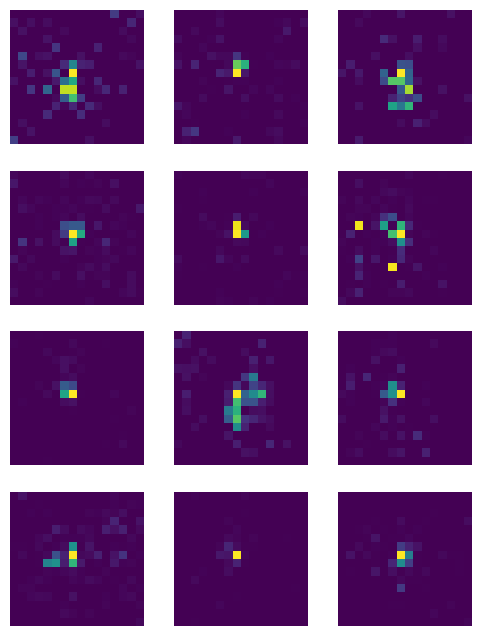

((10000, 16, 16), (10000,))

In [60]:
Test_x,  Test_t  = jb.load('../../datasets/quark_gluon_test.pkl.gz')
train_x, train_t = jb.load('../../datasets/quark_gluon_train.pkl.gz')

plot_images(Test_x)
Test_x.shape, Test_t.shape

### Prepare training and validation datasets

In [7]:
M = int(len(Test_x)/2 + 0.1)

test_x, val_x = Test_x[:M], Test_x[M:]
test_t, val_t = Test_t[:M], Test_t[M:]

n_train = len(train_x)
n_valid = len(val_x)
n_test  = len(test_x)

print("number of images for training:   %10d" % n_train)
print("number of images for validation: %10d" % n_valid)
print("number of images for testing:    %10d" % n_test)

number of images for training:        50000
number of images for validation:       5000
number of images for testing:          5000


### Building a model as a Python class

The __nn.Sequential__ class is the simplest way to construct (simple) PyTorch models. But if you want more control over the model, you can achieve this by building the model as a class inheriting from __nn.Module__ as in the following cell. 

We use some notebook magic to write the following cell to a file, which can then be imported into another notebook. Note: we need to import the saved class to make it visible to this notebook!

In [27]:
%%writefile CNN.py

import torch.nn as nn

model = nn.Sequential(
    
    # image shape: (-1, 1, 16, 16) => (-1, 4, 16, 16)
    nn.Conv2d(in_channels=1,   # input channels
              out_channels=4,  # output channels
              kernel_size=3,   # 3x3 filter
              stride=1,
              padding=1),
    
    # image shape: (-1, 4, 16, 16) => (-1, 4, 8, 8)
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),

    # image shape: (-1, 4, 8, 8) => (-1, 4, 8, 8)
    nn.Conv2d(in_channels=4,   # input channels
              out_channels=4,  # output channels
              kernel_size=3,
              stride=1,
              padding=1),

    # image shape: (-1, 4, 8, 8) => (-1, 4, 4, 4)
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    nn.Flatten(),
    
    nn.Linear(4*4*4, 2),
    
    nn.Dropout(p=0.2),
    
    nn.Softmax(dim=1) 
        )

Overwriting CNN.py


### Define loss function

In [28]:
class AverageLoss():
    def __init__(self):
        pass
    
    def __call__(self, outputs, targets):
        """
        outputs:  shape (batch_size, number_classes), pre-softmax outputs
        targets:  shape (batch_size, ), class indices [0,...,C-1] 
        """        
        # ---------------------------------------------------------------       
        # The cross entropy is defined by
        #   H(p, q) = -sum_i p_i log(q_i)
        #
        # The entropy is defined by
        #   H(p)    = -sum_i p_i log(p_i)
        #
        # and the Kullback-Leibler divergence by
        #   D(p||q) = -sum_i p_i log(p_i/q_i)
        #           = -sum_i p_i log(p_i) + sum_i p_i log(q_i)
        #           = H(p) - H(p, q)
        #
        # The cross entropy is minimized when the estimated 
        # probabilities q_i match the true probabilities p_i, in which 
        # case the cross entropy equals the entropy.
        # --------------------------------------------------------------- 
        # Note the numpy-like syntax for accessing elements of the
        # tensor: outputs[list1, list2] 
        # Note also: range(batch_size) is [0,...batch_size-1]
        #
        # outputs is a (-1, 10) tensor. For each image pick the output 
        # value corresponding to its class. Recall that targets is 
        # a 1D tensor (basically, a 1D array) of class labels. 
        # For every row, we pick the value in the column corresponding
        # to the class label.
        batch_size = len(outputs)
        outputs    = outputs[range(batch_size), targets]
        return -torch.mean(torch.log(outputs))

In [29]:
avloss = AverageLoss()

### Get batch
Get a random sample from the training set of size $batch\_size$

In [30]:
def randomBatch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "number" integers from 
    # the range [0, length-1] 
    rows    = rnd.choice(len(x), batch_size)
    # pick out rows defined by the integers in array "rows"
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

### Accuracy
Fraction of correct predictions

In [31]:
def accuracy(outputs, targets):
    # For each image, return its predicted class label using argmax.
    #
    # argmax scans the numpy along the specified axis, here the 
    # horizontal axis, which is in the class direction, and returns the
    # ordinal value of the maximum value, which is the predicted class. 
    # Note: outputs must be converted from a tensor to a numpy array 
    # before being passed to argmax. axis=1 is to numpy what dim=1 is
    # to PyTorch.
    outputs = np.argmax(outputs.data.numpy(), axis=1)
    
    # count how often the predicted class matches the actual class and
    # compute the fraction of correct predictions. 
    # Note: targets must be converted to a numpy array for the 
    # comparison to work since outputs is a numpy array.
    return float(np.mean(outputs==targets.data.numpy()))

### Trainer

In [32]:
def train(model, optimizer, loss_fn, train_x, train_t, batch_size):
    model.train() # training mode
    
    # get a random sequence of training data
    batch_x, batch_t = randomBatch(train_x, train_t, batch_size)
    H, W = batch_x.shape[-2:]
    
    # convert data from numpy arrays to tensors
    with torch.no_grad():  # no need to compute gradients wrt. to x, t
        x = torch.from_numpy(batch_x).view(-1, 1, H, W)     # change to shape (N, C, H, W)
        t = torch.from_numpy(batch_t)       
    
    # compute output of model
    y = model(x)
    
    # compute loss functions, given the model outputs and the targets
    loss    = loss_fn(y, t)        
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients
    optimizer.step()       # move one step
        
def validate(model, train_x, train_t, val_x, val_t):
    n_val = len(val_x)
    model.eval() # evaluation mode
    
    with torch.no_grad():  # no need to compute gradients wrt. to x, t
        
        batch_x, batch_t = randomBatch(train_x, train_t, n_val)
        H, W = batch_x.shape[-2:]
        x = torch.from_numpy(batch_x).view(-1, 1, H, W)
        t = torch.from_numpy(batch_t)       
        y = model(x)
        acc_t = accuracy(y, t)
          
        batch_x, batch_t = randomBatch(val_x, val_t, n_val)  
        x = torch.from_numpy(batch_x).view(-1, 1, H, W)
        t = torch.from_numpy(batch_t)      
        y = model(x)
        acc_v = accuracy(y, t)

    return (acc_t, acc_v)
               
def trainModel(model, optimizer, averageloss, modelfile,
               train_x, train_t,
               val_x, val_t,
               n_iterations, batch_size, 
               xx=[], yy_t=[], yy_v=[], step=100):

    max_acc_v = -1e30
    print('%10s\t%10s\t%10s' % ('iteration', 'training', 'validation'))
    
    for ii in range(n_iterations):
        train(model, optimizer, averageloss, 
              train_x, train_t, 
              batch_size)

        if ii  < 5:
            acc_t, acc_v = validate(model, 
                                    train_x, train_t, 
                                    val_x, val_t)
            
            print("%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v))
            
            if len(xx) == 0:
                xx.append(0)
            else:
                xx.append(xx[-1]+step)
            yy_t.append(acc_t)
            yy_v.append(acc_v)

        elif ii % step == 0:
            acc_t, acc_v = validate(model, 
                                    train_x, train_t, 
                                    val_x, val_t)
            
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), end='')

            xx.append(xx[-1]+step)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
        if acc_v > max_acc_v:
            max_acc_v = acc_v
            torch.save(model.state_dict(), modelfile)
            
    print()
    return (xx, yy_t, yy_v)

### Create an instance of the model and choose minimizer

In [33]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [52]:
import CNN
importlib.reload(CNN)

model = CNN.model
print(model)
print('number of parameters:', number_of_parameters(model))

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=64, out_features=2, bias=True)
  (8): Dropout(p=0.2, inplace=False)
  (9): Softmax(dim=1)
)
number of parameters: 318


### Train!

During training, the model parameters are saved to **jet_cnn.dict** every time the current best prediction accuracy, using the validation data, is exceeded. 

In [53]:
modelfile = 'jet_cnn.dict'
xx   = []  # iteration numbers
yy_t = []  # prediction accuracy using training data
yy_v = []  # prediction accuracy using validation data

In [54]:
def plot(xx, yy_t, yy_v):
    # create an empty figure
    fig = plt.figure(figsize=(6, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    # axis limits
    ax.set_ylim((0.5, 0.80))
    ax.set_xlim((xx[0], xx[-1]))
    
    ax.plot(xx, yy_t, 'b', label='Training')
    ax.plot(xx, yy_v, 'r', label='Validation')
    
    ax.set_title('Training and Validation Accuracy', fontsize=16)
    ax.set_xlabel('Iterations', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.grid(True, which="both", linestyle='-')
    
    ax.legend(loc='lower right')
    fig.tight_layout()
    plt.savefig('accuracy.png')
    plt.show()

 iteration	  training	validation
         0	    0.4988	    0.5134
         1	    0.5098	    0.5142
         2	    0.4952	    0.5106
         3	    0.4976	    0.5020
         4	    0.4854	    0.5210
      5950	    0.7036	    0.6916

done!


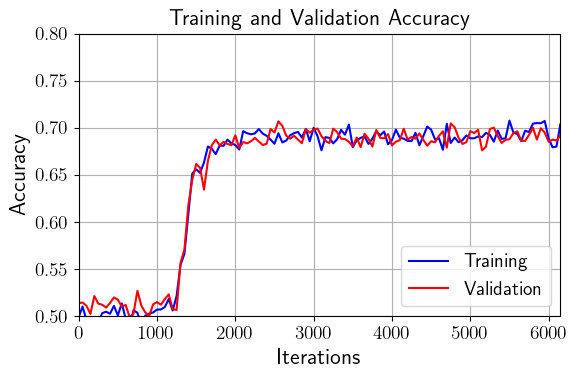

In [55]:
n_iter  =  6000    # number of iterations
n_batch =   128    # number of images/training batch
step = 50
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

xx, yy_t, yy_v = trainModel(model, optimizer, avloss, modelfile,
                            train_x, train_t, 
                            val_x,   val_t,
                            n_iter,  n_batch, 
                            xx, yy_t, yy_v, 
                            step=step)

print("\ndone!")

plot(xx, yy_t, yy_v)

### Compute accuracy on test data

In [56]:
# if use_saved_model = False, use current parameters of trained model,
# otherwise use model with largest prediction accuracy computed using
# validation data.
use_saved_model = True
if use_saved_model:
    model.load_state_dict(torch.load(modelfile))

# remember to restructure inputs as an 
# (N, C, H, W) = (-1, 1, 16, 16) tensor
x = torch.from_numpy(test_x).view(-1, 1, 16, 16)
t = torch.from_numpy(test_t)

model.eval()
y = model(x)
a = accuracy(y, t)

print('Percentage of correct predictions: %8.1f%s' % (100*a, '%'))

Percentage of correct predictions:     69.2%
